
<h1> Using MOMENT for Imputation </h1>
<hr>

## Contents
### 1. A Quick Introduction to Imputation
### 2. Loading MOMENT
### 3. Inputs and Outputs
### 4. Zero-shot Imputation
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.1 Masking Time Series Patches
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.2 Imputation using MOMENT
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.3 Results
### 5. Example Code to Fine-tune MOMENT for Imputation

## 1. A Quick Introduction to Imputation

Multivariate time series are prevalent in real world applications such as finance, meteorology and healthcare. These time series often contain missing values due to various reasons, including equipment malfunctions and human errors. Missing values can impede the meaningful analyis of time series, and hence numerous studies have focused on the task of imputing these missing values using machine learning methodologies. In this tutorial, we will use MOMENT to address the issue of missing values. Formally, the imputation task can be defined as follows:

**Problem**: We are given a time series $T = [x_1, ..., x_L], \ x_i \in \mathbb{R}^{C}$ of length $L$ with $C$ channels (sensors or variables), and a boolean mask of same length $mask = [m_1, ..., m_L]$ indicating missing values. The objective of the imputation problem is to infer missing values and recover the original time series.

## 2. Loading MOMENT

We will first install the MOMENT package, load some essential packages and the pre-trained model. 

MOMENT can be loaded in 4 modes: (1) `reconstruction`, (2) `embedding`, (3) `forecasting`, and (4) `classification`.

In the `reconstruction` mode, MOMENT reconstructs input time series, potentially containing missing values. We can solve imputation and anomaly detection problems in this mode. This mode is suitable for solving imputation and anomaly detection tasks. During pre-training, MOMENT is trained to predict the missing values within uniformly randomly masked patches (disjoint sub-sequences) of the input time series, leveraging information from observed data in other patches. As a result, MOMENT comes equipped with a pre-trained reconstruction head, enabling it to address imputation and anomaly detection challenges in a zero-shot manner! Check out the `anomaly_detection.ipynb` notebook for more details!

In the `embedding` model, MOMENT learns a $d$-dimensional embedding (e.g., $d=1024$ for `MOMENT-1-large`) for each input time series. These embeddings can be used for clustering and classification. MOMENT can learn embeddings in a zero-shot setting! Check out `representation_learning.ipynb` and `classification.ipynb` notebooks for more details! 

The `forecasting` and `classification` modes are used for forecasting and classification tasks, respectively. In these modes, MOMENT learns representations which are subsequently mapped to the forecast horizon or the number of classes, using linear forecasting and classification heads. Both the forecasting and classification head are randomly initialized, and therefore must be fine-tuned before use. Check out the `forecasting.ipynb` and `classification.ipynb` notebooks for more details!

In [1]:
%load_ext autoreload
%autoreload 2
from momentfm.utils.utils import control_randomness
control_randomness(seed=13) # Set random seeds for PyTorch, Numpy etc.

/gpt/data3/KURC/users/makamx0a/venvs/moment/lib/python3.11/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
from momentfm import MOMENTPipeline
from torchsummary import summary

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={'task_name': 'reconstruction'} # For imputation, we will load MOMENT in `reconstruction` mode
)
model.init()

In [3]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

In [4]:
# Number of parameters in the encoder
num_params = sum(p.numel() for p in model.encoder.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 341231104


## 3. Inputs and Outputs

Let's begin by performing a forward pass through MOMENT and examining its outputs!

MOMENT takes 3 inputs: 
1. An input time series of length $T=512$ timesteps and $C$ channels, and 
2. Two optional masks, both of length $T=512$. 
    - The input mask is utilized to regulate the time steps or patches that the model should attend to. For instance, in the case of shorter time series, you may opt not to attend to padding. To implement this, you can provide an input mask with zeros in the padded locations.  
    - The second mask, referred to simply as mask, denotes masked or unobserved values. We employ mask tokens to replace all patches containing any masked time step (for further details, refer to Section 3.2 in our [paper](https://arxiv.org/abs/2402.03885)). MOMENT can attend to these mask tokens during reconstruction.
    - By default, all time steps are observed and attended to.

MOMENT returns a `TimeseriesOutputs` object. Since this is a reconstruction task, it returns a `reconstruction` of the input. 

In [5]:
from pprint import pprint
import torch

# takes in tensor of shape [batch_size, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x)
pprint(output)

TimeseriesOutputs(forecast=None,
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]),
                  reconstruction=tensor([[[-0.0572,  0.0067,  0.0385,  ...,  0.2469, -0.2358, -0.0586]],

        [[-0.0850, -0.0467,  0.1126,  ...,  0.2218,  0.0837,  0.0849]],

        [[ 0.1014, -0.3116,  0.1800,  ...,  0.2697, -0.2687,  0.2318]],

        ...,

        [[-0.0375, -0.0908, -0.0936,  ..., -0.0506, -0.0161, -0.0

In [6]:
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## 4. Zero-shot Imputation

Now we'll show you how to use MOMENT to do zero-shot imputation!

In these experiments, we will use Hourly Electricity Transformer Temperature (ETTh1) dataset introduced by [Zhou et al., 2020](https://arxiv.org/abs/2012.07436). Check out [ETDataset](https://github.com/zhouhaoyi/ETDataset) for more information! We will use the ETTh1 dataset since missing values are common in this domain!

We'll start by reading and pre-processing this dataset using the `InformerDataset` class. Since we can do zero-shot imputation, we will just load the testing part of this data. Note that MOMENT was not exposed to the testing part of this dataset during pre-training. 

In [65]:
from data import WellLogDataset, CustomWellLogDataset
from torch.utils.data import Dataset, DataLoader

from config import Config
batch_size = 192
global_configs = Config('../.config/settings.yaml')
ARAMCO_LOGS = os.path.join(global_configs.data, 'alphas', 'logs/cali_tokenized/')
root_dir = ARAMCO_LOGS
test_dataset = CustomWellLogDataset(root_dir, task_name='imputation', data_split="train",  few_shot=14400)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [66]:
test_dataset[0][0].shape

torch.Size([5, 512])

Now let's visualize the time series

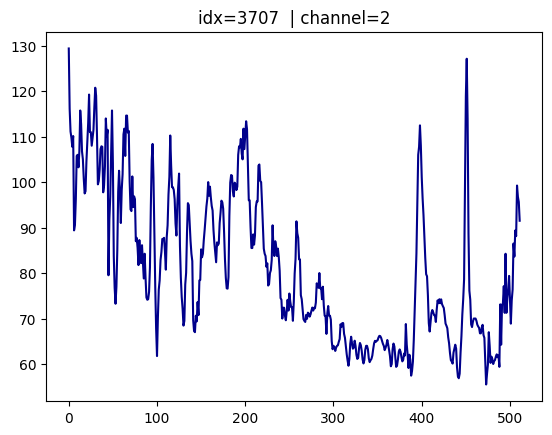

In [67]:
import numpy as np
import matplotlib.pyplot as plt

n_channels = test_dataset[0][0].shape[0]
idx = np.random.randint(0, len(test_dataset))
channel_idx = np.random.randint(0, n_channels)
plt.plot(test_dataset[idx][0][channel_idx, :].squeeze(), c='darkblue')
plt.title(f'idx={idx}  | channel={channel_idx}')
plt.show()

### 4.1 Masking Time Series Patches

Since there are no missing values in this dataset, we will randomly mask time series subsequences to evaluate MOMENT's ability to reason about missing values. Instead of masking individual time steps at random, we will mask time series patches uniformly at random using the `Masking` class.

In [87]:
from momentfm.utils.masking import Masking

mask_generator = Masking(mask_ratio=0.05) # Mask 25% of patches randomly 

### 4.2 Imputation using MOMENT

Since there are no missing values in this dataset, we will randomly mask time series subsequences to evaluate MOMENT's ability to reason about missing values. Instead of masking individual time steps at random, we will mask time series patches uniformly at random using the `Masking` class.

In [88]:
from tqdm import tqdm

device = "cuda:1" if torch.cuda.is_available() else "cpu"
model = model.to(device).float()

trues, preds, masks = [], [], []
with torch.no_grad():
    for batch_x, batch_masks in tqdm(test_dataloader, total=len(test_dataloader)):
        trues.append(batch_x.numpy())
        
        batch_x = batch_x.to(device).float()
        n_channels = batch_x.shape[1]
        
        # Reshape to [batch_size * n_channels, 1, window_size]
        batch_x = batch_x.reshape((-1, 1, 512)) 
        
        batch_masks = batch_masks.to(device).long()
        batch_masks = batch_masks.repeat_interleave(n_channels, axis=0)
        
        mask = mask_generator.generate_mask(
            x=batch_x, input_mask=batch_masks).to(device).long()

        output = model(batch_x, input_mask=batch_masks, mask=mask) # [batch_size, n_channels, window_size]
        
        reconstruction = output.reconstruction.detach().cpu().numpy()
        mask = mask.detach().squeeze().cpu().numpy()
        
        # Reshape back to [batch_size, n_channels, window_size]
        reconstruction = reconstruction.reshape((-1, n_channels, 512)) 
        mask = mask.reshape((-1, n_channels, 512))
                
        preds.append(reconstruction)
        masks.append(mask)

preds = np.concatenate(preds)
trues = np.concatenate(trues)
masks = np.concatenate(masks)

print(f"Shapes: preds={preds.shape} | trues={trues.shape} | masks={masks.shape}")

100%|██████████| 35/35 [00:37<00:00,  1.07s/it]

Shapes: preds=(6606, 5, 512) | trues=(6606, 5, 512) | masks=(6606, 5, 512)


### 4.3 Results

Since there are no missing values in this dataset, we will randomly mask time series subsequences to evaluate MOMENT's ability to reason about missing values. Instead of masking individual time steps at random, we will mask time series patches uniformly at random using the `Masking` class.

In [89]:
from momentfm.utils.forecasting_metrics import mse, mae

print(f"Mean Squarred Error (MSE)={mse(y=trues[masks==0], y_hat=preds[masks==0], reduction='mean')}")
print(f"Mean Absolute Error (MAE)={mae(y=trues[masks==0], y_hat=preds[masks==0], reduction='mean')}")

Mean Squarred Error (MSE)=26.347158432006836
Mean Absolute Error (MAE)=1.4237676858901978


Now let's visualize random time series windows! White patches are masked and black patches are observed.

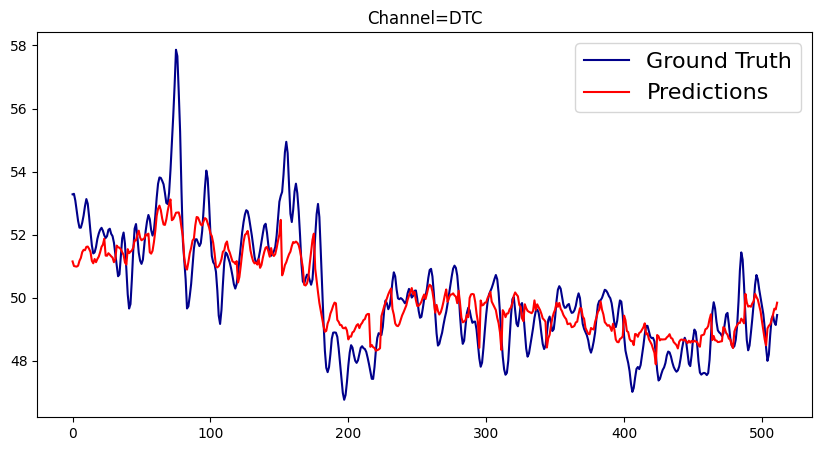

In [90]:
idx = np.random.randint(trues.shape[0])
channel_idx = 2

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.set_title(f"Channel=DTC")
axs.plot(trues[idx, channel_idx, :].squeeze(), label='Ground Truth', c='darkblue')
axs.plot(preds[idx, channel_idx, :].squeeze(), label='Predictions', c='red')
axs.legend(fontsize=16)

#axs[1].imshow(np.tile(masks[np.newaxis, idx, channel_idx], reps=(8, 1)), cmap='binary')
plt.show()

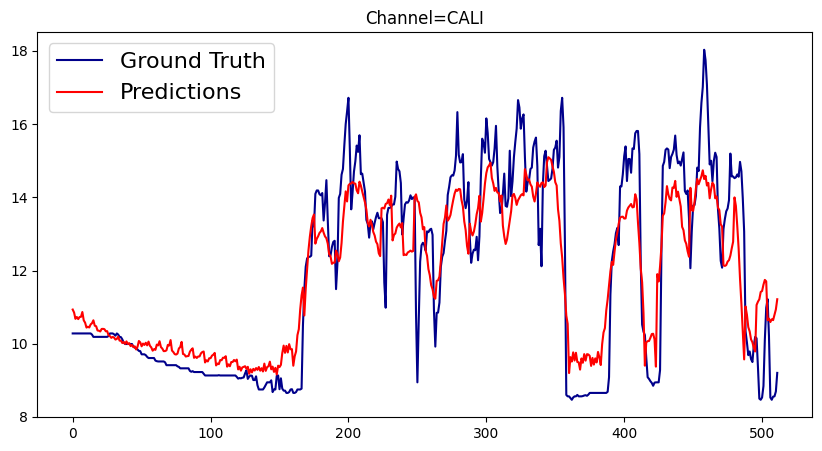

In [104]:
idx = np.random.randint(trues.shape[0])
channel_idx = 4

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.set_title(f"Channel=CALI")
axs.plot(trues[idx, channel_idx, :].squeeze(), label='Ground Truth', c='darkblue')
axs.plot(preds[idx, channel_idx, :].squeeze(), label='Predictions', c='red')
axs.legend(fontsize=16)

#axs[1].imshow(np.tile(masks[np.newaxis, idx, channel_idx], reps=(8, 1)), cmap='binary')
plt.show()

## 5. Example Code to Fine-tune MOMENT for Imputation

To improve MOMENT's imputation performance, you can fine-tune it on any dataset. In our [paper](https://arxiv.org/abs/2402.03885), we fine-tune the final reconstruction head, but you can also fine-tune the entire model on your data. Here is some example code:

```python

# Optimize Mean Squarred Error using your favourite optimizer
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

mask_generator = Masking(mask_ratio=0.3) # Mask 30% of patches randomly 

for batch_x, batch_masks in tqdm(test_dataloader, total=len(test_dataloader)):
    n_channels = batch_x.shape[1]
    
    # Reshape to [batch_size * n_channels, 1, window_size]
    batch_x = batch_x.reshape((-1, 1, 512)) 
    
    batch_masks = batch_masks.to(device).long()
    batch_masks = batch_masks.repeat_interleave(n_channels, axis=0)
    
    # Randomly mask some patches of data
    mask = mask_generator.generate_mask(
        x=batch_x, input_mask=batch_masks).to(device).long()

    # Forward
    output = model(batch_x, input_mask=batch_masks, mask=mask) 
    
    # Compute loss
    recon_loss = criterion(output.reconstruction, original)
    observed_mask = batch_masks * (1 - mask)
    masked_loss = observed_mask * recon_loss
    
    loss = masked_loss.nansum() / (observed_mask.nansum() + 1e-7)
    
    print(f"loss: {loss.item()}")
    
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```